In [152]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [153]:
name_notebook = '0830-mh_em_1qm_loop'

In [154]:
# return last line of the file
def read_version(name_notebook):
    day = name_notebook.split('-')[0]
    file = open(initial_path + "checkpoints/" + day + "/versions/" + name_notebook + ".version", "r")
    version = int(file.readlines()[-1])
    return version


In [155]:
version = read_version(name_notebook)

losses = []
n_qubits = []
n_layers = []

for i in range(1, version + 1):
    day = name_notebook.split('-')[0]

    # loss
    file_path = initial_path + "checkpoints/" + day + "/txts/" + name_notebook + "_validation_" + str(i) + ".txt"
    try: 
        file = open(file_path, "r")
    except:
        print("File not found: " + file_path)
        continue
    loss = float(file.readlines()[-1].split()[-1])

    # number of layers and qubits
    file_path = initial_path + "checkpoints/" + day + "/txts/" + name_notebook + "_model_str_" + str(i) + ".txt"
    lines = [line.replace('\t', '').replace('\n', '') for line in open(file_path, "r").readlines()]
    layers = int([line for line in lines if 'block_n_layers' in line][0].split(' ')[-1])
    qubits = int([line for line in lines if 'n_qubits' in line][0].split(' ')[-1])

    # append data
    losses.append(loss)
    n_qubits.append(qubits)
    n_layers.append(layers)


File not found: ../checkpoints/0830/txts/0830-mh_em_1qm_loop_validation_1.txt
File not found: ../checkpoints/0830/txts/0830-mh_em_1qm_loop_validation_16.txt
File not found: ../checkpoints/0830/txts/0830-mh_em_1qm_loop_validation_22.txt
File not found: ../checkpoints/0830/txts/0830-mh_em_1qm_loop_validation_31.txt


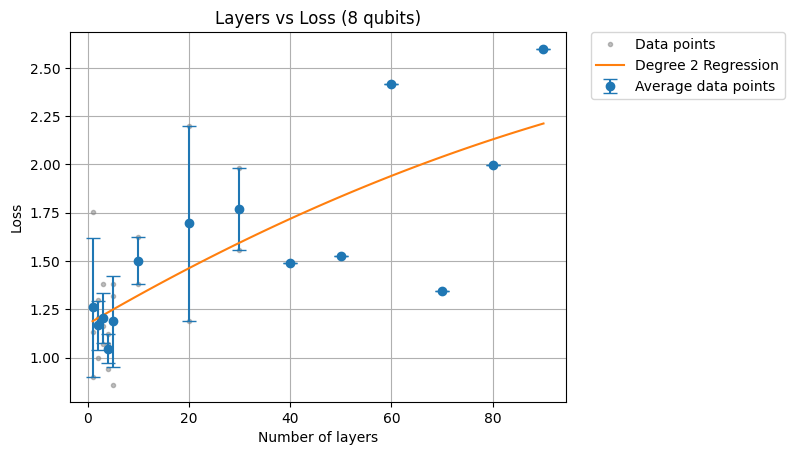

In [156]:
# Given data
y = np.array(losses)
x = np.array(n_layers)

# Order the data by x values
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Average the loss for the same number of layers
x_avg = np.array(list(set(x)))
y_avg = np.array([np.mean(y[x == xi]) for xi in x_avg])
y_std = np.array([np.std(y[x == xi]) for xi in x_avg])  # Standard deviation for error bars

# Polynomial Regression data
degree = 2
coefficients = np.polyfit(x, y, degree)
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = np.polyval(coefficients, x_pred)

# Plot
plt.plot(x, y, 'o', label="Data points", alpha=0.5, color='grey', markersize=3)        # Data points
plt.errorbar(x_avg, y_avg, yerr=y_std, fmt='o', label="Average data points", capsize=5)  # Data points with error bars
plt.plot(x_pred, y_pred, '-', label="Degree {} Regression".format(degree))  # Regression line
plt.xlabel('Number of layers')
plt.ylabel('Loss')
plt.title('Layers vs Loss ('+ str(n_qubits[0]) + ' qubits)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

